# Basic SARIMAX model on weekly data

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from pmdarima import auto_arima

from collections import OrderedDict

In [2]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
# function for getting log cases
def log_cases(df):
    df = df.assign(logged_cases = lambda df: np.log(df['total_cases']+1))
    return df

In [4]:
# function for evaluation of models
def model_classification(actual, predicted): 
    """
    Prints out RSME, MAE and explained variance score
    """
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [5]:
def SARIMAX_evaluation(train, test, exogs, max_p=3, max_q=3, max_P=1, max_Q=1, d=1, D=0, verbose=False):
    results = {}
    for p in range(0,max_p+1):
        for q in range(0,max_q+1):
            for P in range(0,max_P+1):
                for Q in range(0,max_Q1+1):
                    try:
                        model = SARIMAX(train.total_cases, 
                                       order=(p, d, q),
                                       seasonal_order=(P, D, Q, 12),
                                       exog=train[exogs])
                        res = model.fit(disp=0)
                        pred = res.forecast(len(test.total_cases), exog=test[exogs])
                        rmse = round(np.sqrt(mean_squared_error(test.total_cases, pred)),2)
                        results[f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}'] = rmse
                        if verbose:
                            print(f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}: RSME {rmse}')

                    except ValueError:
                        results[f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}'] = np.nan
    return results

In [6]:
def SARIMAX_evaluation_pq(train, test, exogs, max_p=3, max_q=3, P=1, Q=1, d=1, D=0, verbose=False):
    results = {}
    for p in range(0,max_p+1):
        for q in range(0,max_q+1):
            try:
                model = SARIMAX(train.total_cases, 
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, 12),
                               exog=train[exogs])
                res = model.fit(disp=0, maxiter=400, method_kwargs={"warn_convergence": False})
                pred = res.forecast(len(test.total_cases), exog=test[exogs])
                rmse = round(np.sqrt(mean_squared_error(test.total_cases, pred)),2)
                results[f'Combination: ({p}, {d}, {q}), ({P}, {D}, {Q})'] = rmse
                if verbose:
                    print(f'Combination: ({p}, {d}, {q}), ({P}, {D}, {Q}): RSME {rmse}')

            except ValueError:
                results[f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}'] = np.nan
    return results

In [7]:
def SARIMAX_evaluation_PQ(train, test, exogs, max_P=3, max_Q=3, p=1, q=1, d=1, D=0, verbose=False):
    results = {}
    for P in range(0,max_P+1):
        for Q in range(0,max_Q+1):
            try:
                model = SARIMAX(train.total_cases, 
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, 12),
                               exog=train[exogs])
                res = model.fit(disp=0, maxiter=400, method_kwargs={"warn_convergence": False})
                pred = res.forecast(len(test.total_cases), exog=test[exogs])
                rmse = round(np.sqrt(mean_squared_error(test.total_cases, pred)),2)
                results[f'Combination: ({p}, {d}, {q}), ({P}, {D}, {Q})'] = rmse
                if verbose:
                    print(f'Combination: ({p}, {d}, {q}), ({P}, {D}, {Q}): RSME {rmse}')

            except ValueError:
                results[f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}'] = np.nan
    return results

## Load the data

In [8]:
data_subsets_lags = pickle.load(open('data_subsets_lags.pickle', 'rb'))

sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = data_subsets_lags

In [9]:
# get log of cases as column
sj_train_train = log_cases(sj_train_train)
sj_train_test = log_cases(sj_train_test)
iq_train_train = log_cases(iq_train_train)
iq_train_test = log_cases(iq_train_test)

In [10]:
# delete non-numeric columns
sj_train_train = sj_train_train.select_dtypes(include='number')
iq_train_train = iq_train_train.select_dtypes(include='number')

In [11]:
# delet also NAN included by lagged precipitation 
sj_train_train = sj_train_train.dropna()
sj_train_test = sj_train_test.dropna()
iq_train_train = iq_train_train.dropna()
iq_train_test = iq_train_test.dropna()

### Scaler

In [12]:
features = sj_train_train.columns.tolist()
not_features = ['logged_cases', 'total_cases', 'month', 'weekofyear', 'year']
features = [x for x in features if x not in not_features]

In [13]:
sj_scaler = StandardScaler()
sj_train_train_s = sj_scaler.fit_transform(sj_train_train[features])
sj_train_test_s = sj_scaler.transform(sj_train_test[features])

sj_train_train_s = pd.DataFrame(sj_train_train_s)
sj_train_train_s.columns = features
sj_train_train_s.index = sj_train_train.index

sj_train_train_scaled = sj_train_train[not_features]
sj_train_train_scaled = sj_train_train_scaled.join(sj_train_train_s)

sj_train_test_s = pd.DataFrame(sj_train_test_s)
sj_train_test_s.columns = features
sj_train_test_s.index = sj_train_test.index

sj_train_test_scaled = sj_train_test[not_features]
sj_train_test_scaled = sj_train_test_scaled.join(sj_train_test_s)

In [14]:
iq_scaler = StandardScaler()
iq_train_train_s = iq_scaler.fit_transform(iq_train_train[features])
iq_train_test_s = iq_scaler.transform(iq_train_test[features])

iq_train_train_s = pd.DataFrame(iq_train_train_s)
iq_train_train_s.columns = features
iq_train_train_s.index = iq_train_train.index

iq_train_train_scaled = iq_train_train[not_features]
iq_train_train_scaled = iq_train_train_scaled.join(iq_train_train_s)

iq_train_test_s = pd.DataFrame(iq_train_test_s)
iq_train_test_s.columns = features
iq_train_test_s.index = iq_train_test.index

iq_train_test_scaled = iq_train_test[not_features]
iq_train_test_scaled = iq_train_test_scaled.join(iq_train_test_s)

In [15]:
sj_train_train_scaled = sj_train_train_scaled.dropna()
sj_train_test_scaled = sj_train_test_scaled.dropna()
iq_train_train_scaled = iq_train_train_scaled.dropna()
iq_train_test_scaled = iq_train_test_scaled.dropna()

## San Juan - total cases
First order differencing

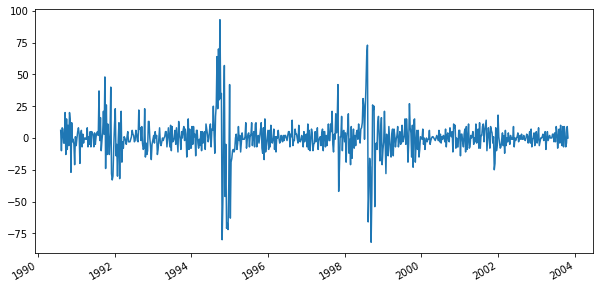

In [16]:
sj_train_train_diff = sj_train_train - sj_train_train.shift(1)
sj_train_train_diff = sj_train_train_diff.dropna()

sj_train_train_diff.total_cases.plot();

### ACF

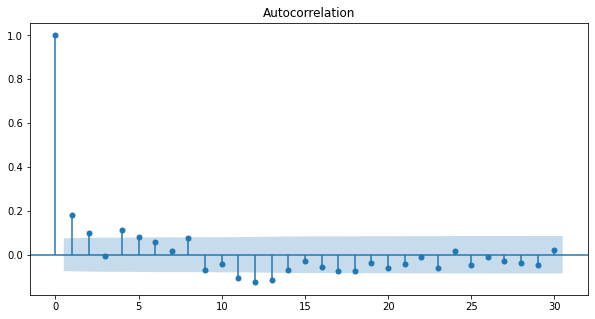

In [17]:
# Check the PACF for the optimal number of lags
plot_acf(sj_train_train_diff.total_cases, lags=30);

### PCAF

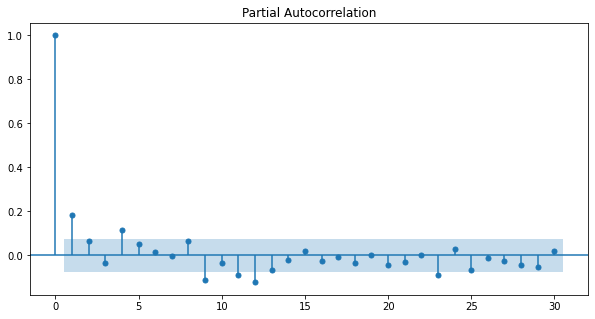

In [18]:
# Check the PACF for the optimal number of lags
plot_pacf(sj_train_train_diff.total_cases, lags=30);

In [19]:
corr_mat = sj_train_train.corr()
cases_corr_list = (
    corr_mat['total_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

station_avg_temp_c_lag8           0.354404
station_min_temp_c_lag8           0.351633
station_avg_temp_c_lag7           0.345911
station_min_temp_c_lag7           0.345745
station_min_temp_c_lag6           0.330478
station_avg_temp_c_lag6           0.328557
reanalysis_min_air_temp_c_lag8    0.315839
reanalysis_max_air_temp_c_lag8    0.315635
reanalysis_max_air_temp_c_lag7    0.315531
reanalysis_avg_temp_c_lag8        0.314542
transmission_probability_lag8     0.314373
infection_probability_lag8        0.314246
fecundity_lag8                    0.314227
mdr_lag8                          0.314152
biting_rate_lag8                  0.314092
Name: total_cases, dtype: float64

In [20]:
sj_exogs = cases_corr_list[:15].index.tolist()

In [21]:
sj_train_train_statsmodels = sj_train_train.reset_index(drop=True)
sj_train_test_statsmodels = sj_train_test.reset_index(drop=True)

In [22]:
sj_train_train_statsmodels.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,...,cum_precip_5w_lag8,cum_precip_6w_lag1,cum_precip_6w_lag2,cum_precip_6w_lag3,cum_precip_6w_lag4,cum_precip_6w_lag5,cum_precip_6w_lag6,cum_precip_6w_lag7,cum_precip_6w_lag8,logged_cases
0,1990,31,0.170400,0.247150,0.379700,0.381357,34.6,80.584286,32.66,17.594286,...,98.9,151.8,148.9,175.8,117.9,120.8,141.1,128.6,114.9,2.890372
1,1990,32,0.180317,0.064333,0.164443,0.138857,20.0,79.650000,28.80,17.950000,...,120.0,168.3,151.8,148.9,175.8,117.9,120.8,141.1,128.6,3.178054
2,1990,33,0.185275,0.128033,0.206957,0.168243,101.9,84.178571,90.75,18.515714,...,99.7,158.6,168.3,151.8,148.9,175.8,117.9,120.8,141.1,2.639057
3,1990,34,0.190233,0.168800,0.167657,0.172286,25.9,80.947143,32.40,18.174286,...,116.8,202.2,158.6,168.3,151.8,148.9,175.8,117.9,120.8,3.091042
4,1990,35,0.252900,0.330750,0.264171,0.284314,39.8,83.348571,40.94,18.515714,...,112.1,143.9,202.2,158.6,168.3,151.8,148.9,175.8,117.9,3.367296


---
### Evaluation of right p and q values

In [24]:
#results_sj_pq = SARIMAX_evaluation_pq(train=sj_train_train_statsmodels, test=sj_train_test_statsmodels, exogs=sj_exogs)

In [ ]:
#results_sj_pq = OrderedDict(sorted(results_sj_pq.items(), key=lambda x: x[1]))
#results_sj_pq

In [ ]:
#results_sj_PQ = SARIMAX_evaluation_PQ(train=sj_train_train_statsmodels, test=sj_train_test_statsmodels, exogs=sj_exogs, p=0, q=0)

In [ ]:
#results_sj_PQ = OrderedDict(sorted(results_sj_PQ.items(), key=lambda x: x[1]))
#results_sj_PQ

In [ ]:
#results_sj_pq1 = SARIMAX_evaluation_pq(train=sj_train_train_statsmodels, test=sj_train_test_statsmodels, P=3, Q=2, exogs=sj_exogs, verbose=True)

In [25]:
#results_sj_pq1 = OrderedDict(sorted(results_sj_pq1.items(), key=lambda x: x[1]))
#results_sj_pq1

---

In [26]:
sj_order = (2, 1, 2) # Non-seasonal mid1 because differencing with order 1
sj_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
sj_sarimax_model = SARIMAX(sj_train_train_statsmodels.total_cases, 
                           order=sj_order,
                           seasonal_order=sj_seasonal_order,
                           exog=sj_train_train_statsmodels[sj_exogs])
sj_sarimax_model_fit = sj_sarimax_model.fit(maxiter=400)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06493D+00    |proj g|=  2.23026D-02

At iterate    5    f=  4.06383D+00    |proj g|=  2.81662D-02

At iterate   10    f=  4.06030D+00    |proj g|=  2.25143D-03

At iterate   15    f=  4.05970D+00    |proj g|=  4.75676D-03

At iterate   20    f=  4.05959D+00    |proj g|=  4.54369D-03

At iterate   25    f=  4.05951D+00    |proj g|=  4.02510D-04

At iterate   30    f=  4.05949D+00    |proj g|=  3.23301D-03

At iterate   35    f=  4.05943D+00    |proj g|=  2.15666D-03

At iterate   40    f=  4.05942D+00    |proj g|=  1.08108D-03

At iterate   45    f=  4.05940D+00    |proj g|=  1.36646D-03

At iterate   50    f=  4.05940D+00    |proj g|=  3.55542D-04

At iterate   55    f=  4.05939D+00    |proj g|=  8.84683D-04

At iterate   60    f=  4.05939D+00    |proj g|=  7.19000D-04

At iterate   65    f=  4.0

In [27]:
print(sj_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          total_cases   No. Observations:                  690
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -2800.805
Date:                              Thu, 05 Aug 2021   AIC                           5645.609
Time:                                      23:46:43   BIC                           5745.385
Sample:                                           0   HQIC                          5684.207
                                              - 690                                         
Covariance Type:                                opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
station_avg_temp_c_lag8           -0.3832      1.936     -

In [35]:
sj_sarimax_model_pred = sj_sarimax_model_fit.forecast(len(sj_train_test_statsmodels.total_cases), exog=sj_train_test_statsmodels[sj_exogs])

In [36]:
sj_sarimax_model_pred = pd.Series(sj_sarimax_model_pred) 
sj_sarimax_model_pred.index=sj_train_test.index 

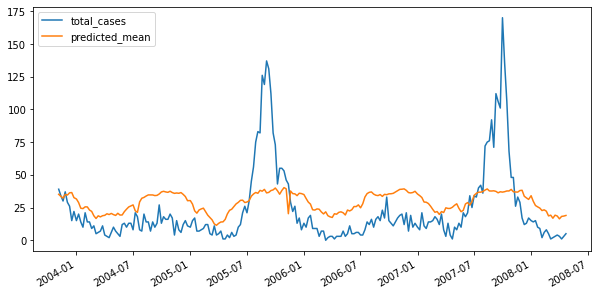

In [37]:
sj_train_test.total_cases.plot(legend=True)
sj_sarimax_model_pred.plot(legend=True);

In [38]:
model_classification(sj_train_test.total_cases, sj_sarimax_model_pred)

--------------------
RMSE: 26.22
--------------------
MAE: 19.51
Explained variance: 0.208
--------------------


---
## San Juan with scaled data

In [130]:
corr_mat = sj_train_train_scaled.corr()
cases_corr_list = (
    corr_mat['total_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

station_avg_temp_c_lag8           0.354404
station_min_temp_c_lag8           0.351633
station_avg_temp_c_lag7           0.345911
station_min_temp_c_lag7           0.345745
station_min_temp_c_lag6           0.330478
station_avg_temp_c_lag6           0.328557
reanalysis_min_air_temp_c_lag8    0.315839
reanalysis_max_air_temp_c_lag8    0.315635
reanalysis_max_air_temp_c_lag7    0.315531
reanalysis_avg_temp_c_lag8        0.314542
transmission_probability_lag8     0.314373
infection_probability_lag8        0.314246
fecundity_lag8                    0.314227
mdr_lag8                          0.314152
biting_rate_lag8                  0.314092
Name: total_cases, dtype: float64

In [131]:
sj_exogs = cases_corr_list[:15].index.tolist()

In [132]:
sj_train_train_statsmodels = sj_train_train_scaled.reset_index(drop=True)
sj_train_test_statsmodels = sj_train_test_scaled.reset_index(drop=True)

In [133]:
sj_order = (2, 1, 2) # Non-seasonal mid1 because differencing with order 1
sj_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
sj_sarimax_model = SARIMAX(sj_train_train_statsmodels.total_cases, 
                           order=sj_order,
                           seasonal_order=sj_seasonal_order,
                           exog=sj_train_train_statsmodels[sj_exogs])
sj_sarimax_model_fit = sj_sarimax_model.fit(maxiter=400)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06495D+00    |proj g|=  2.24009D-02

At iterate    5    f=  4.06387D+00    |proj g|=  2.76893D-02

At iterate   10    f=  4.06034D+00    |proj g|=  2.25855D-03

At iterate   15    f=  4.05962D+00    |proj g|=  4.39276D-03

At iterate   20    f=  4.05956D+00    |proj g|=  3.65880D-03

At iterate   25    f=  4.05950D+00    |proj g|=  3.60597D-04

At iterate   30    f=  4.05947D+00    |proj g|=  1.05580D-03

At iterate   35    f=  4.05943D+00    |proj g|=  7.66212D-04

At iterate   40    f=  4.05942D+00    |proj g|=  1.60841D-03

At iterate   45    f=  4.05940D+00    |proj g|=  9.74553D-04

At iterate   50    f=  4.05939D+00    |proj g|=  5.01546D-04

At iterate   55    f=  4.05938D+00    |proj g|=  3.54969D-04

At iterate   60    f=  4.05937D+00    |proj g|=  3.46387D-04

At iterate   65    f=  4.0

In [134]:
print(sj_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          total_cases   No. Observations:                  690
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -2800.797
Date:                              Fri, 06 Aug 2021   AIC                           5645.594
Time:                                      00:15:44   BIC                           5745.369
Sample:                                           0   HQIC                          5684.191
                                              - 690                                         
Covariance Type:                                opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
station_avg_temp_c_lag8           -0.4708      2.674     -

In [135]:
sj_sarimax_model_pred = sj_sarimax_model_fit.forecast(len(sj_train_test_statsmodels.total_cases), exog=sj_train_test_statsmodels[sj_exogs])

In [136]:
sj_sarimax_model_pred = pd.Series(sj_sarimax_model_pred) 
sj_sarimax_model_pred.index=sj_train_test.index 

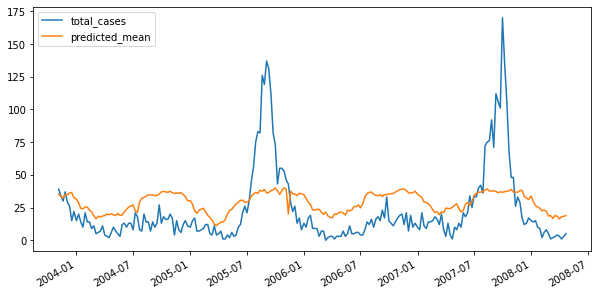

In [137]:
sj_train_test.total_cases.plot(legend=True)
sj_sarimax_model_pred.plot(legend=True);

In [138]:
model_classification(sj_train_test.total_cases, sj_sarimax_model_pred)

--------------------
RMSE: 26.18
--------------------
MAE: 19.43
Explained variance: 0.209
--------------------


---

## San Juan - logged values and scaled

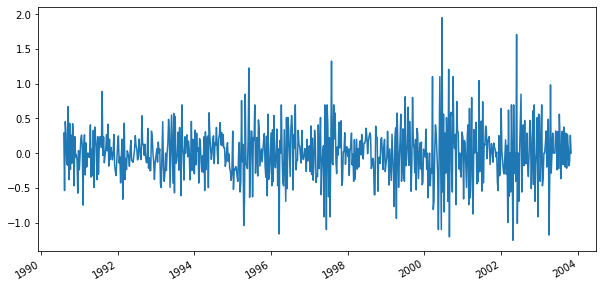

In [39]:
sj_train_train_diff = sj_train_train - sj_train_train.shift(1)
sj_train_train_diff = sj_train_train_diff.dropna()

sj_train_train_diff.logged_cases.plot();

### ACF

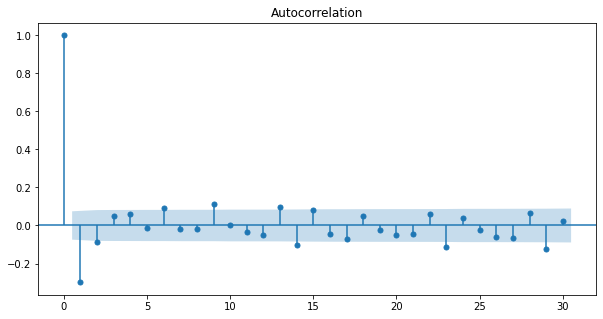

In [40]:
# Check the PACF for the optimal number of lags
plot_acf(sj_train_train_diff.logged_cases, lags=30);

### PCAF

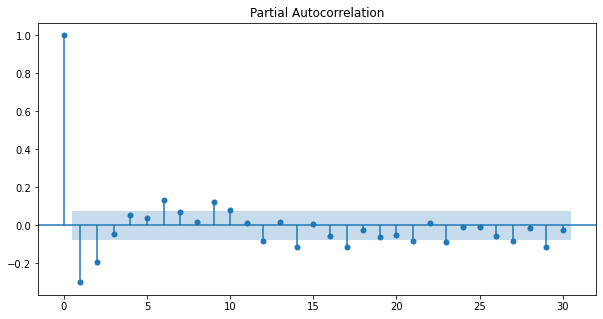

In [41]:
# Check the PACF for the optimal number of lags
plot_pacf(sj_train_train_diff.logged_cases, lags=30);

In [139]:
corr_mat = sj_train_train_scaled.corr()
cases_corr_list = (
    corr_mat['logged_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

reanalysis_specific_humidity_g_per_kg_lag8    0.502824
reanalysis_dew_point_temp_c_lag8              0.500359
reanalysis_specific_humidity_g_per_kg_lag7    0.480124
reanalysis_dew_point_temp_c_lag7              0.476841
station_avg_temp_c_lag8                       0.476745
reanalysis_min_air_temp_c_lag8                0.469055
station_min_temp_c_lag8                       0.464031
fecundity_lag8                                0.462976
reanalysis_max_air_temp_c_lag8                0.461717
transmission_probability_lag8                 0.460771
infection_probability_lag8                    0.460528
mdr_lag8                                      0.459655
biting_rate_lag8                              0.458917
reanalysis_min_air_temp_c_lag7                0.457994
pdr_lag8                                      0.457693
Name: logged_cases, dtype: float64

In [140]:
sj_exogs = cases_corr_list[:15].index.tolist()

In [141]:
#sj_exogs = [
    'station_avg_temp_c_lag8',
    'station_min_temp_c_lag8',
    'station_avg_temp_c_lag7',
    'station_min_temp_c_lag7',
    'station_min_temp_c_lag6',
    'station_avg_temp_c_lag6',
    'reanalysis_min_air_temp_c_lag8',
    'reanalysis_max_air_temp_c_lag8',
    'reanalysis_max_air_temp_c_lag7',
    'reanalysis_avg_temp_c_lag8',
    'transmission_probability_lag8',
    'infection_probability_lag8',
    'fecundity_lag8',
    'mdr_lag8',
    'biting_rate_lag8'
]

IndentationError: unexpected indent (1711179502.py, line 2)

In [142]:
sj_train_train_statsmodels = sj_train_train_scaled.reset_index(drop=True)
sj_train_test_statsmodels = sj_train_test_scaled.reset_index(drop=True)

In [143]:
sj_order = (3, 1, 2) # Non-seasonal mid1 because differencing with order 1
sj_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
sj_sarimax_model = SARIMAX(sj_train_train_statsmodels.logged_cases, 
                           order=sj_order,
                           seasonal_order=sj_seasonal_order,
                           exog=sj_train_train_statsmodels[sj_exogs])
sj_sarimax_model_fit = sj_sarimax_model.fit(maxiter=400)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73111D-01    |proj g|=  9.23628D-02


 This problem is unconstrained.



At iterate    5    f=  3.69071D-01    |proj g|=  1.05474D-02

At iterate   10    f=  3.68884D-01    |proj g|=  5.88504D-03

At iterate   15    f=  3.68693D-01    |proj g|=  2.70259D-03

At iterate   20    f=  3.68675D-01    |proj g|=  1.16050D-03

At iterate   25    f=  3.68582D-01    |proj g|=  9.95149D-03

At iterate   30    f=  3.68532D-01    |proj g|=  2.49426D-03

At iterate   35    f=  3.68521D-01    |proj g|=  2.12301D-03

At iterate   40    f=  3.68490D-01    |proj g|=  1.69411D-03

At iterate   45    f=  3.68487D-01    |proj g|=  4.00443D-04

At iterate   50    f=  3.68483D-01    |proj g|=  4.88040D-04

At iterate   55    f=  3.68482D-01    |proj g|=  3.64283D-03

At iterate   60    f=  3.68478D-01    |proj g|=  1.52975D-03

At iterate   65    f=  3.68469D-01    |proj g|=  1.08628D-03

At iterate   70    f=  3.68464D-01    |proj g|=  1.70999D-03

At iterate   75    f=  3.68399D-01    |proj g|=  7.42073D-03

At iterate   80    f=  3.68376D-01    |proj g|=  1.48776D-03

At iter

/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate  400    f=  3.67739D-01    |proj g|=  3.80222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23    400    434      1     0     0   3.802D-04   3.677D-01
  F =  0.36773886515794268     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [144]:
print(sj_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         logged_cases   No. Observations:                  690
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -253.740
Date:                              Fri, 06 Aug 2021   AIC                            553.480
Time:                                      00:21:53   BIC                            657.790
Sample:                                           0   HQIC                           593.831
                                              - 690                                         
Covariance Type:                                opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per

In [145]:
sj_sarimax_model_pred_log = sj_sarimax_model_fit.forecast(len(sj_train_test_statsmodels.logged_cases), exog=sj_train_test_statsmodels[sj_exogs])

In [146]:
sj_sarimax_model_pred = np.exp(sj_sarimax_model_pred_log)-1

In [147]:
sj_sarimax_model_pred = pd.Series(sj_sarimax_model_pred) 
sj_sarimax_model_pred.index=sj_train_test.index 

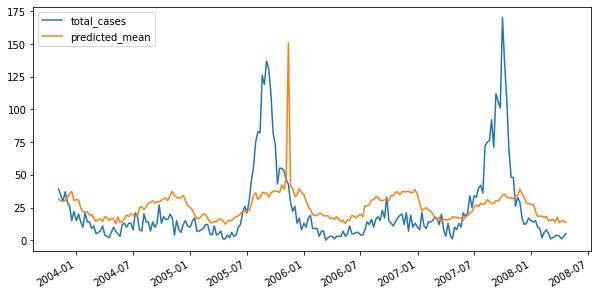

In [148]:
sj_train_test.total_cases.plot(legend=True)
sj_sarimax_model_pred.plot(legend=True);

In [149]:
model_classification(sj_train_test.total_cases, sj_sarimax_model_pred)

--------------------
RMSE: 26.54
--------------------
MAE: 17.56
Explained variance: 0.148
--------------------


---
# Iquitos

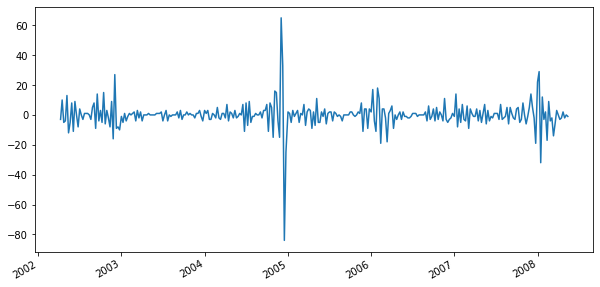

In [71]:
iq_train_train_diff = iq_train_train - iq_train_train.shift(1)
iq_train_train_diff = iq_train_train_diff.dropna()

iq_train_train_diff.total_cases.plot();

### ACF

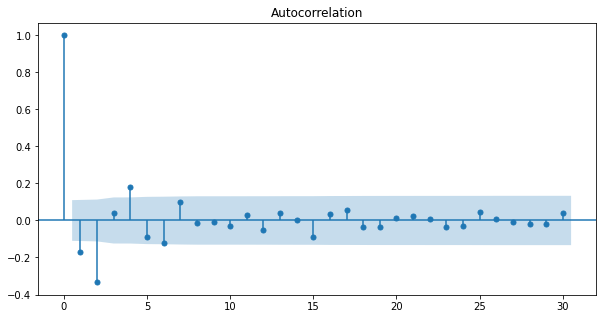

In [72]:
# Check the PACF for the optimal number of lags
plot_acf(iq_train_train_diff.total_cases, lags=30);

### PCAF

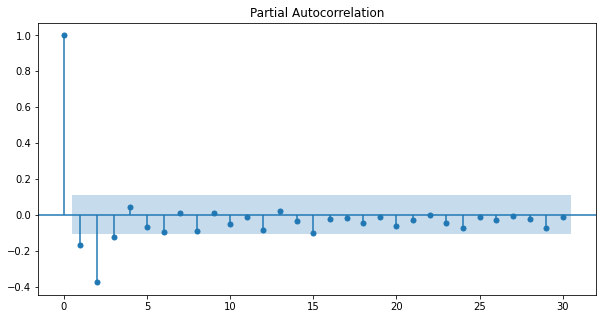

In [73]:
# Check the PACF for the optimal number of lags
plot_pacf(iq_train_train_diff.total_cases, lags=30);

## Selection of parameter

In [74]:
corr_mat = iq_train_train.corr()
cases_corr_list = (
    corr_mat['total_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

reanalysis_specific_humidity_g_per_kg_lag2    0.207099
reanalysis_min_air_temp_c                     0.205019
reanalysis_min_air_temp_c_lag2                0.199620
reanalysis_specific_humidity_g_per_kg_lag1    0.199519
reanalysis_dew_point_temp_c_lag2              0.199417
reanalysis_dew_point_temp_c_lag1              0.193619
fecundity_lag7                                0.189499
fecundity_lag5                                0.187945
reanalysis_specific_humidity_g_per_kg         0.187924
transmission_probability_lag7                 0.187838
infection_probability_lag7                    0.187705
reanalysis_specific_humidity_g_per_kg_lag3    0.187383
mdr_lag7                                      0.187075
biting_rate_lag7                              0.186516
transmission_probability_lag5                 0.185981
Name: total_cases, dtype: float64

In [75]:
iq_exogs = cases_corr_list[:15].index.tolist()

In [ ]:
#iq_exogs = [
    'reanalysis_specific_humidity_g_per_kg_lag2',
    'reanalysis_min_air_temp_c',
    'reanalysis_min_air_temp_c_lag2',
    'reanalysis_specific_humidity_g_per_kg_lag1',
    'reanalysis_dew_point_temp_c_lag2',
    'reanalysis_dew_point_temp_c_lag1',
    'fecundity_lag7',
    'fecundity_lag5',
    'reanalysis_specific_humidity_g_per_kg',
    'transmission_probability_lag7',
    'infection_probability_lag7',
    'reanalysis_specific_humidity_g_per_kg_lag3',
    'mdr_lag7',
    'biting_rate_lag7',
    'transmission_probability_lag5'
]

---
# Evaluation of right p and q

## Autoarima to check for different hyperparameters

In [ ]:
#auto_arima(y=iq_train_train['total_cases'], m=12, X=iq_train_train[iq_exogs], trace=True, n_jobs=-1, stepwise=False,
#          max_p=6, max_d=4, max_q=6, 
#          max_P=6, max_D=4, max_Q=6)

# always give the same output for both cities

---

In [76]:
iq_train_train_statsmodels = iq_train_train.reset_index(drop=True)
iq_train_test_statsmodels = iq_train_test.reset_index(drop=True)

In [80]:
iq_order = (3, 0, 3) # Non-seasonal mid1 because differencing with order 1
iq_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
iq_sarimax_model = SARIMAX(iq_train_train_statsmodels.total_cases, 
                           order=iq_order,
                           seasonal_order=iq_seasonal_order,
                           exog=iq_train_train_statsmodels[iq_exogs])
iq_sarimax_model_fit = iq_sarimax_model.fit(maxiter=400)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48006D+00    |proj g|=  6.03853D-02

At iterate    5    f=  3.47755D+00    |proj g|=  1.97030D-02

At iterate   10    f=  3.47625D+00    |proj g|=  3.55579D-03

At iterate   15    f=  3.47598D+00    |proj g|=  4.04694D-03

At iterate   20    f=  3.47565D+00    |proj g|=  4.88516D-03

At iterate   25    f=  3.47556D+00    |proj g|=  6.81014D-03

At iterate   30    f=  3.47546D+00    |proj g|=  3.02028D-03

At iterate   35    f=  3.47536D+00    |proj g|=  6.14255D-03

At iterate   40    f=  3.47515D+00    |proj g|=  2.96856D-03

At iterate   45    f=  3.47494D+00    |proj g|=  4.69814D-03

At iterate   50    f=  3.47464D+00    |proj g|=  5.82041D-03

At iterate   55    f=  3.47445D+00    |proj g|=  3.46885D-03

At iterate   60    f=  3.47432D+00    |proj g|=  3.12187D-03

At iterate   65    f=  3.4

/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [81]:
print(iq_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          total_cases   No. Observations:                  319
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood               -1107.388
Date:                              Thu, 05 Aug 2021   AIC                           2262.776
Time:                                      23:57:51   BIC                           2353.141
Sample:                                           0   HQIC                          2298.864
                                              - 319                                         
Covariance Type:                                opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per

In [82]:
iq_sarimax_model_pred = iq_sarimax_model_fit.forecast(len(iq_train_test_statsmodels.total_cases), exog=iq_train_test_statsmodels[iq_exogs])

In [83]:
iq_sarimax_model_pred = pd.Series(iq_sarimax_model_pred) 
iq_sarimax_model_pred.index=iq_train_test.index 

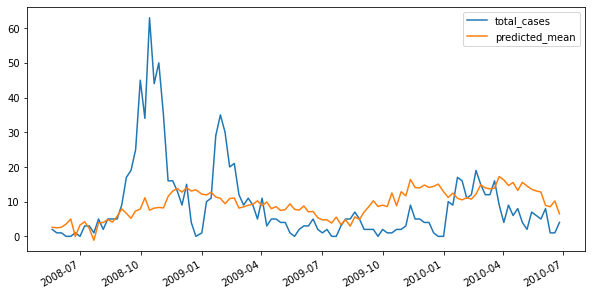

In [84]:
iq_train_test.total_cases.plot(legend=True)
iq_sarimax_model_pred.plot(legend=True);

In [85]:
model_classification(iq_train_test.total_cases, iq_sarimax_model_pred)

--------------------
RMSE: 11.51
--------------------
MAE: 7.43
Explained variance: -0.041
--------------------


---
# Iquitos - lagged and scaled

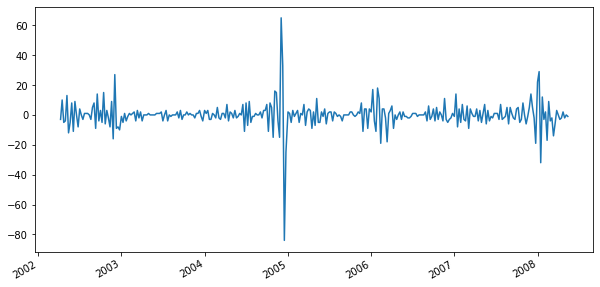

In [150]:
iq_train_train_diff = iq_train_train - iq_train_train.shift(1)
iq_train_train_diff = iq_train_train_diff.dropna()

iq_train_train_diff.total_cases.plot();

### ACF

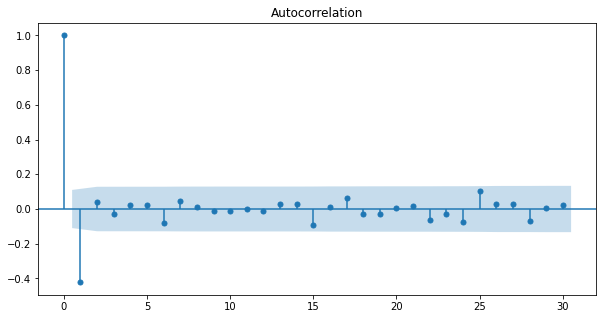

In [151]:
# Check the PACF for the optimal number of lags
plot_acf(iq_train_train_diff.logged_cases, lags=30);

### PCAF

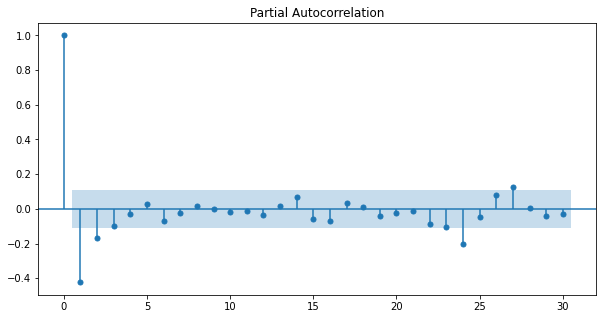

In [152]:
# Check the PACF for the optimal number of lags
plot_pacf(iq_train_train_diff.logged_cases, lags=30);

## Selection of parameter

In [153]:
corr_mat = iq_train_train_scaled.corr()
cases_corr_list = (
    corr_mat['logged_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

reanalysis_specific_humidity_g_per_kg_lag3    0.272324
reanalysis_dew_point_temp_c_lag3              0.266025
reanalysis_min_air_temp_c_lag3                0.263004
reanalysis_min_air_temp_c_lag5                0.251482
reanalysis_min_air_temp_c_lag4                0.250022
reanalysis_specific_humidity_g_per_kg_lag5    0.249386
reanalysis_specific_humidity_g_per_kg_lag2    0.247081
reanalysis_min_air_temp_c_lag2                0.245847
reanalysis_specific_humidity_g_per_kg_lag1    0.245220
reanalysis_dew_point_temp_c_lag5              0.245193
reanalysis_dew_point_temp_c_lag1              0.240080
reanalysis_dew_point_temp_c_lag2              0.239024
reanalysis_specific_humidity_g_per_kg         0.234172
reanalysis_min_air_temp_c_lag1                0.232481
reanalysis_min_air_temp_c                     0.226011
Name: logged_cases, dtype: float64

In [154]:
iq_exogs = cases_corr_list[:15].index.tolist()

In [155]:
#iq_exogs = [
    'reanalysis_specific_humidity_g_per_kg_lag2',
    'reanalysis_min_air_temp_c',
    'reanalysis_min_air_temp_c_lag2',
    'reanalysis_specific_humidity_g_per_kg_lag1',
    'reanalysis_dew_point_temp_c_lag2',
    'reanalysis_dew_point_temp_c_lag1',
    'fecundity_lag7',
    'fecundity_lag5',
    'reanalysis_specific_humidity_g_per_kg',
    'transmission_probability_lag7',
    'infection_probability_lag7',
    'reanalysis_specific_humidity_g_per_kg_lag3',
    'mdr_lag7',
    'biting_rate_lag7',
    'transmission_probability_lag5'
]

IndentationError: unexpected indent (479969529.py, line 2)

In [157]:
iq_train_train_statsmodels = iq_train_train_scaled.reset_index(drop=True)
iq_train_test_statsmodels = iq_train_test_scaled.reset_index(drop=True)

In [158]:
iq_order = (2, 1, 2) # Non-seasonal mid1 because differencing with order 1
iq_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
iq_sarimax_model = SARIMAX(iq_train_train_statsmodels.logged_cases, 
                           order=iq_order,
                           seasonal_order=iq_seasonal_order,
                           exog=iq_train_train_statsmodels[iq_exogs])
iq_sarimax_model_fit = iq_sarimax_model.fit(maxiter=400)

/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00142D+00    |proj g|=  5.14263D-01

At iterate    5    f=  8.74083D-01    |proj g|=  1.00860D-02

At iterate   10    f=  8.73504D-01    |proj g|=  6.20840D-03

At iterate   15    f=  8.73358D-01    |proj g|=  2.17217D-03

At iterate   20    f=  8.72794D-01    |proj g|=  2.04853D-02

At iterate   25    f=  8.72281D-01    |proj g|=  1.47652D-03

At iterate   30    f=  8.72265D-01    |proj g|=  1.59090D-03

At iterate   35    f=  8.72230D-01    |proj g|=  2.34311D-03

At iterate   40    f=  8.72169D-01    |proj g|=  7.21710D-04

At iterate   45    f=  8.72168D-01    |proj g|=  2.28650D-04

At iterate   50    f=  8.72165D-01    |proj g|=  1.32401D-03

At iterate   55    f=  8.72161D-01    |proj g|=  1.44705D-04

At iterate   60    f=  8.72160D-01    |proj g|=  2.67753D-04

At iterate   65    f=  8.7

In [159]:
print(iq_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         logged_cases   No. Observations:                  319
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -273.753
Date:                              Fri, 06 Aug 2021   AIC                            591.507
Time:                                      00:24:12   BIC                            674.272
Sample:                                           0   HQIC                           624.564
                                              - 319                                         
Covariance Type:                                opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per

In [160]:
iq_sarimax_model_pred_log = iq_sarimax_model_fit.forecast(len(iq_train_test_statsmodels.total_cases), exog=iq_train_test_statsmodels[iq_exogs])

In [161]:
iq_sarimax_model_pred = np.exp(iq_sarimax_model_pred_log)-1

In [162]:
iq_sarimax_model_pred = pd.Series(iq_sarimax_model_pred) 
iq_sarimax_model_pred.index=iq_train_test.index 

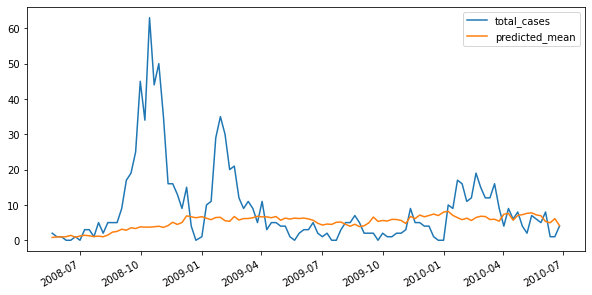

In [163]:
iq_train_test.total_cases.plot(legend=True)
iq_sarimax_model_pred.plot(legend=True);

In [164]:
model_classification(iq_train_test.total_cases, iq_sarimax_model_pred)

--------------------
RMSE: 12.12
--------------------
MAE: 6.93
Explained variance: -0.035
--------------------
